<a href="https://colab.research.google.com/github/tanmayChava/Emotion-Prediction/blob/main/Emotion_Prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
### Facial expressions are one of the most powerful and universal forms of non-verbal communication.
### They can convey emotions such as happiness, sadness, anger, fear, surprise, and more without the need for words.

### The goal of this project is to build a Facial Emotion Recognition (FER) system that can automatically detect a person’s emotional state from an image using Deep Learning.
### We use the FER-2013 dataset, which contains grayscale facial images categorized into seven emotions:

### Angry 😠

### Disgusted 🤢

### Fearful 😨

### Happy 😃

### Neutral 😐

### Sad 😢

### Surprised 😲

### Objectives
### Preprocess and scale the dataset for model training.

### Build and train a Convolutional Neural Network (CNN) to classify facial emotions.

### Evaluate the model’s performance on unseen data.

### Suggest potential improvements for higher accuracy.

### Prepare the model for possible real-time emotion recognition applications.

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanmaychavhan","key":"aa73f7a4738513a25482bbeb7b26d870"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
  0% 0.00/65.2M [00:00<?, ?B/s]
100% 65.2M/65.2M [00:00<00:00, 1.19GB/s]


In [ ]:
!unzip -q emotion-detection-fer.zip -d ./emotion-detection-fer

In [ ]:
import os

base_dir = "./emotion-detection-fer"
print("Subfolders in dataset directory:")
print(os.listdir(base_dir))

Subfolders in dataset directory:
['train', 'test']


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your training directory
train_dir = '/content/emotion-detection-fer/train'

# Create ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)    # Sacling

# Load all images in one batch (increase batch_size if needed)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),        # Resize to match model input
    color_mode='grayscale',      # Use 'rgb' if color images
    class_mode='categorical',    # One-hot encode the labels
    batch_size=10000,            # Load all data in one batch
    shuffle=True                 # Shuffle data
)

# Extract x_train and y_train
x_train, y_train , x_test , y_test = next(train_generator)


Found 28709 images belonging to 7 classes.


In [ ]:
test_dir = '/content/emotion-detection-fer/test'

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=10000,
    shuffle=False
)

x_test, y_test = next(test_generator)

Found 7178 images belonging to 7 classes.


In [ ]:
# Confirm shapes
print("x_train shape:", x_train.shape)  # (num_samples, 48, 48, 1)
print("y_train shape:", y_train.shape)  # (num_samples, num_classes)

x_train shape: (10000, 48, 48, 1)
y_train shape: (10000, 7)


In [ ]:
class_labels = train_generator.class_indices
print("Class indices:", class_labels)

Class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


# Suffling Images

In [ ]:
import numpy as np

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Shuffle the data
indices = np.arange(len(x_train))
np.random.shuffle(indices)

x_train = x_train[indices]
y_train = y_train[indices]

# 2. Visualize the First 24 Training Images

ValueError: num must be an integer with 1 <= num <= 24, not 25

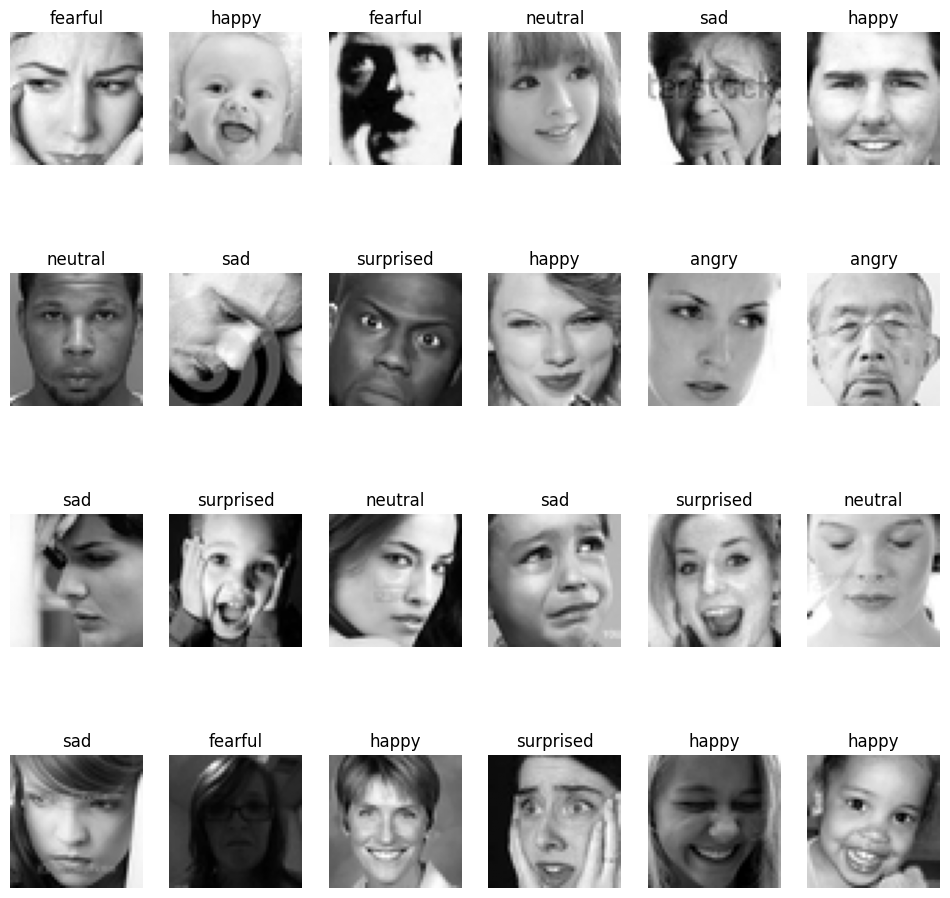

In [ ]:
import matplotlib.pyplot as plt

# Reverse class mapping
index_to_label = {v: k for k, v in train_generator.class_indices.items()}

# Plot 24 shuffled images
plt.figure(figsize=(12, 12))
for i in range(50):
    plt.subplot(4, 6, i + 1)
    image = x_train[i].reshape(48, 48)
    label_index = np.argmax(y_train[i])
    label_name = index_to_label[label_index]

    plt.imshow(image, cmap='gray')
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


# 3 Scaling

In [ ]:
print("Min pixel value:", x_train.min())
print("Max pixel value:", x_train.max())

Min pixel value: 0.0
Max pixel value: 1.0


# Validation Sets

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/emotion-detection-fer/train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/emotion-detection-fer/train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


# Define the Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten and FC layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7, activation='softmax'))  # 7 classes

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423,111 (5.43 MB)

 Trainable params: 1,421,703 (5.42 MB)

 Non-trainable params: 1,408 (5.50 KB)

# Compile the Model

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',                     # Optimizer
    loss='categorical_crossentropy',     # Loss for multi-class classification (one-hot labels)
    metrics=['accuracy']                 # Evaluation metric
)

# Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model (highest val_accuracy)
checkpoint = ModelCheckpoint(
    'best_model.h5',                # File name to save
    monitor='val_accuracy',         # What to monitor
    save_best_only=True,            # Only save best version
    mode='max',                     # Because higher val_accuracy is better
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint]  # <-- This is required
)

Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.6796 - loss: 0.8522
Epoch 1: val_accuracy improved from -inf to 0.59867, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 333s 930ms/step - accuracy: 0.6796 - loss: 0.8522 - val_accuracy: 0.5987 - val_loss: 1.1308
Epoch 2/30
  1/358 ━━━━━━━━━━━━━━━━━━━━ 4:37 778ms/step - accuracy: 0.7344 - loss: 0.7323
Epoch 2: val_accuracy did not improve from 0.59867
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.7344 - loss: 0.7323 - val_accuracy: 0.5974 - val_loss: 1.1257
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.7022 - loss: 0.8029
Epoch 3: val_accuracy did not improve from 0.59867
358/358 ━━━━━━━━━━━━━━━━━━━━ 382s 975ms/step - accuracy: 0.7022 - loss: 0.8030 - val_accuracy: 0.5274 - val_loss: 1.3229
Epoch 4/30
  1/358 ━━━━━━━━━━━━━━━━━━━━ 4:46 803ms/step - accuracy: 0.6875 - loss: 0.7761
Epoch 4: val_accuracy did not improve from 0.59867
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.6875 - loss: 0.7761 - val_accuracy: 0.5265 - val_loss: 1.3238
Epoch 5/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.7113 - loss: 0.7736
Epoch 5: va

358/358 ━━━━━━━━━━━━━━━━━━━━ 364s 911ms/step - accuracy: 0.7912 - loss: 0.5635 - val_accuracy: 0.6083 - val_loss: 1.2165
Epoch 22/30
  1/358 ━━━━━━━━━━━━━━━━━━━━ 4:32 763ms/step - accuracy: 0.7344 - loss: 0.6108
Epoch 22: val_accuracy did not improve from 0.60832
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.7344 - loss: 0.6108 - val_accuracy: 0.6064 - val_loss: 1.2154
Epoch 23/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8033 - loss: 0.5342
Epoch 23: val_accuracy did not improve from 0.60832
358/358 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8033 - loss: 0.5342 - val_accuracy: 0.5918 - val_loss: 1.2709
Epoch 24/30
  1/358 ━━━━━━━━━━━━━━━━━━━━ 4:36 774ms/step - accuracy: 0.7812 - loss: 0.5450
Epoch 24: val_accuracy did not improve from 0.60832
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.7812 - loss: 0.5450 - val_accuracy: 0.5948 - val_loss: 1.2504
Epoch 25/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.8067 - loss: 0.5234
Epoch 2

# 3. Then Load the Model
# Once training finishes and best_model.h5 is saved:

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have access to the class_indices
index_to_label = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
# Predict using the best model
predictions = best_model.predict(x_test)

# Get class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step


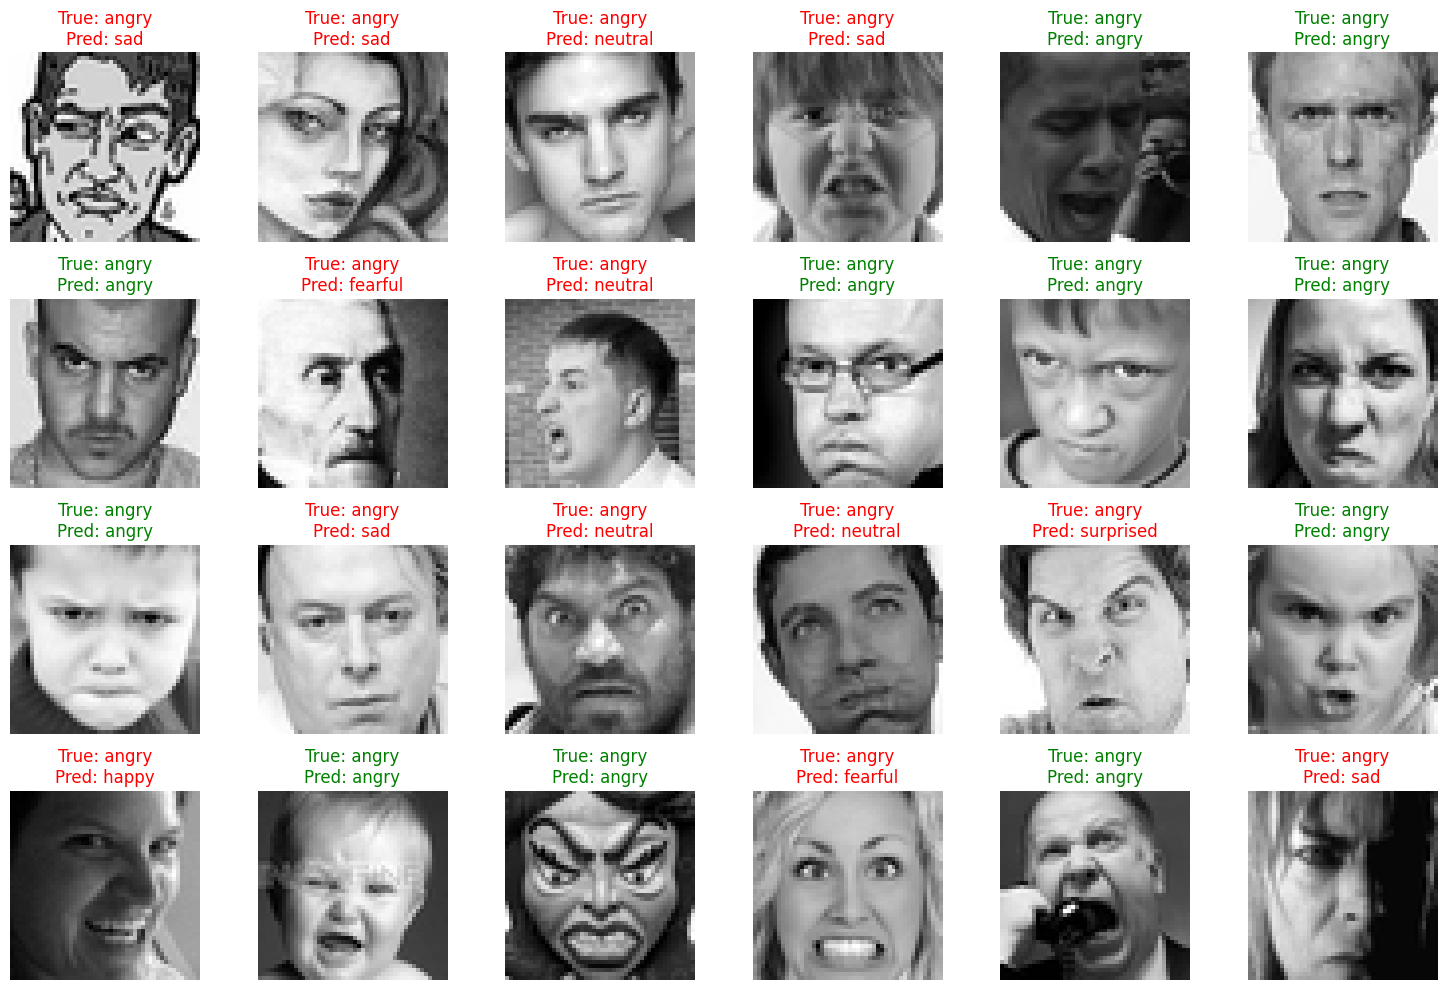

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(24):
    plt.subplot(4, 6, i+1)
    image = x_test[i].reshape(48, 48)  # Reshape grayscale image
    plt.imshow(image, cmap='gray')

    true_label = index_to_label[true_classes[i]]
    pred_label = index_to_label[predicted_classes[i]]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')
score = best_model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 61.0198%


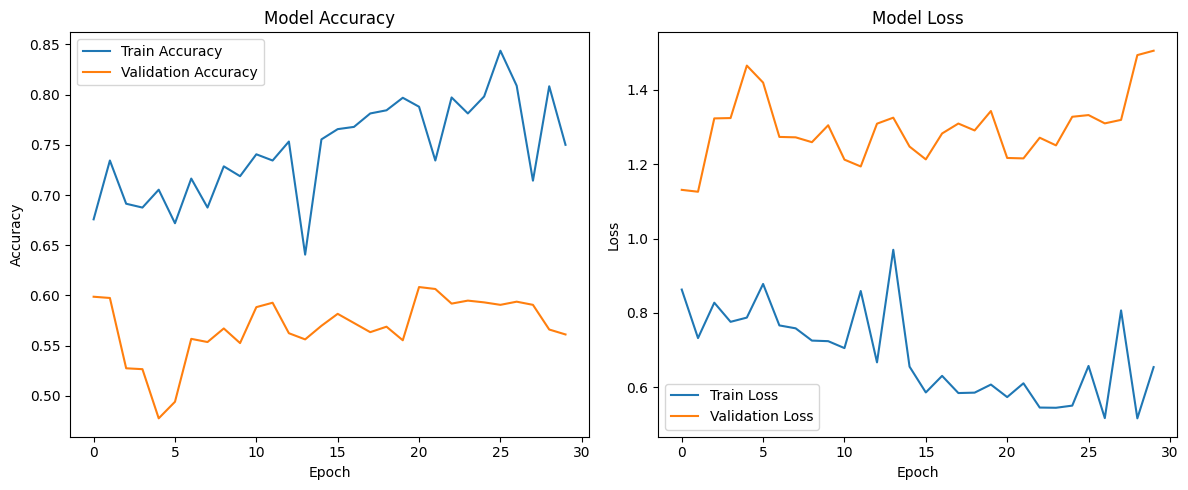

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#  Conclusion
### In this project, we built and trained a Convolutional Neural Network (CNN) for facial emotion recognition using the FER dataset.
### The initial model achieved a test accuracy of ~61%, which shows the model can identify emotions but still has room for improvement.

### From experimentation, we found that accuracy can be improved by:

### Using deeper CNN architectures with Batch Normalization and Dropout for better feature extraction.

### Applying data augmentation (rotation, shift, zoom, flip) to make the model more robust.

### Training for more epochs with EarlyStopping to avoid overfitting.

### Considering class balancing techniques or class weights to handle underrepresented emotions.

### Exploring transfer learning with pre-trained models for better generalization.

### Overall, the model demonstrates the feasibility of emotion detection from facial expressions.
### Future work could involve:

### Using RGB images and transfer learning for higher accuracy.

### Real-time prediction deployment with Streamlit or Flask.

### Optimizing hyperparameters and experimenting with attention mechanisms.